# CIFAR-10: Image Dataset

Throughout this course, we will teach you all basic skills and how to use all neccessary tools that you need to implement deep neural networks, which is the main focus of this class. However, you should also be proficient with handling data and know how to prepare it for your specific task. In fact, most of the jobs that involve deep learning in industry are very data related, so this is an important skill that you have to pick up.

Therefore, we will take a deep dive into data preparation this week by implementing our own datasets and dataloader. In this notebook, we will focus on the image dataset CIFAR-10. The CIFAR-10 dataset consists of 50000 32x32 pixels colour (RGB) images in 10 classes, which are *plane*, *car*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*.

## (Optional) Mount in Google Colab
Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_03) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_03'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

## Imports

Let's start by importing some libraries that you will need along the way, as well as some code files that you will work on throughout this notebook.

In [2]:
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from exercise_code.data import (
    ImageFolderDataset,
)
from exercise_code.tests import (
    test_rescale_transform,
    test_compute_image_mean_and_std,
    test_len_dataset,
    test_item_dataset,
    test_transform_dataset,
    test_normalization_transform,
    save_pickle
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

## 1. Dataset Download
Let us get started by downloading the data. In `exercise_code/data/image_folder_dataset.py` you can find a class `ImageFolderDataset`, which you will have to complete throughout this notebook.

This class automatically downloads the raw data for you. To do so, simply initialize the class as below.

**Note** Downloading and zipping the dataset might take a while, ESPECIALLY if you are using Google Colab. So be patient!

In [ ]:
#if working with colab uncomment the following line
### colab only ###
# import urllib.request
### colab only ###

In [3]:
# Set up the output dataset folder
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
cifar_root = os.path.join(i2dl_exercises_path, "datasets", "cifar10")

# Init the dataset and display downloading information this one time
dataset = ImageFolderDataset(
    root=cifar_root,
    force_download=False,
    verbose=True
)

120725504it [00:10, 11602704.52it/s]                               


Extracting cifar10.zip
Dataset successfully downloaded! Stored under: /home/nilp/tum/i2dl/datasets/cifar10


You should now be able to see the images in `i2dl_exercises/datasets/cifar10` in your file browser, which should contain one subfolder per class, each containing the respective images labeled `0001.png`, `0002.png`, ...

By default, the dataset will only be downloaded the first time you initialize a dataset class. If, for some reason, your version of the dataset gets corrupted and you wish to re-download it, simply initialize the class with `force_download=True` in the download cell above.

**Important notice for colab:**

By running the above cell, the dataset is mounted to the runtime you are currently using. But it takes time to save the dataset to your google drive. The dataset might not be complete saved on your google drive due to many reason. When you restart the runtime or try to access cifar10 from another notebook, you may got error. When this happens, run the following cell in colab to redownload and extract the dataset for the runtime.

In [ ]:
# # only when you got error regarding cifar10 in colab
# !mkdir -p /content/gdrive/MyDrive/i2dl/datasets/cifar10
# !wget -P /content/gdrive/MyDrive/i2dl/datasets/cifar10/ https://i2dl.vc.in.tum.de/static/data/cifar10.zip
# !unzip -o /content/gdrive/MyDrive/i2dl/datasets/cifar10/cifar10.zip -d /content/gdrive/MyDrive/i2dl/datasets/cifar10
# !rm -f /content/gdrive/MyDrive/i2dl/datasets/cifar10/cifar10.zip

## 2. Data Visualization

Before training any model you should *always* take a look at some samples of your dataset. In this way, you can make sure that the data input has worked as intended and also get a feeling for the dataset. 

Let's load the CIFAR-10 data and visualize a subset of the images. To do so, `PIL.Image.open()` is used to open an image, and then `numpy.asarray()` to cast the image to a numpy array, which will have shape (32x32x3). In this way 7 images will be loaded per class, and then use `matplotlib.pyplot` to visualize those images in a grid.

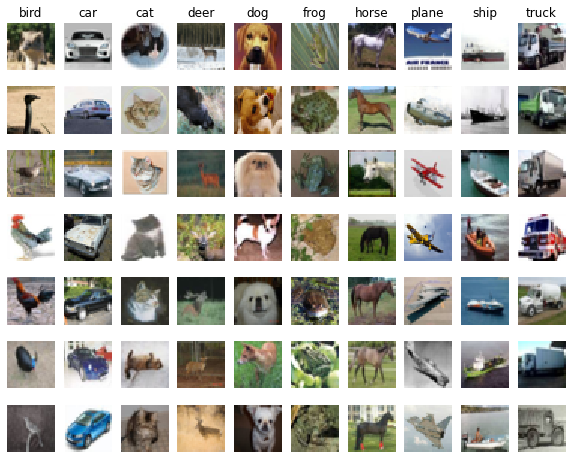

In [4]:
def load_image_as_numpy(image_path):
    return np.asarray(Image.open(image_path), dtype=float)

classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
]
num_classes = len(classes)
samples_per_class = 7
for label, cls in enumerate(sorted(classes)):
    for i in range(samples_per_class):
        image_path = os.path.join(
            cifar_root,
            cls,
            str(i+10).zfill(4) + ".png"
        )  # e.g. cifar10/plane/0001.png
        image = np.asarray(Image.open(image_path))  # open image as numpy array
        plt_idx = i * num_classes + label + 1  # calculate plot location in the grid
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(image.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)  # plot class names above columns
plt.show()

## 3. ImageFolderDataset Implementation

Loading images by following the code above is a bit cumbersome. Therefore, the next step is to write a custom **Dataset** class, which takes care of the data loading. This is always the first thing you have to implement when starting a new deep learning project.

### 3.1 Dataset Class

The **Dataset** class is a wrapper that loads the data from a given file path and returns a dictionary containing already prepared data, as you have done above. Datasets always need to have the following two methods implemented:
- `__len__(self)` is a method that should simply calculate and return the number of images in the dataset. After it is implemented, you can simply call it with `len(dataset)`.
- `__getitem__(self, index)` should return the image with the given index from your dataset. Implementing this will allow you to access your dataset like a list, i.e. you can then simply call `dataset[9]` to access the 10th image in the dataset.

Generally, you will have to implement a different dataset for every project. However, base dataset classes for future projects will be provided for you in future projects.

### 3.2 ImageFolderDataset Implementation

Now it is your turn to implement such a dataset class for CIFAR-10. To do so, open `exercise_code/data/image_folder_dataset.py` and check the following three methods of `ImageFolderDataset`:
- `make_dataset(directory, class_to_idx)` should load the prepared data from a given directory root (`directory`) into two lists (`images` and `labels`). `class_to_idx` is a dict mapping class (e.g. 'cat') to label (e.g. 1). **Note**: This function is called in the `__init__` method of the dataset class only ONCE, and is not intended to be called by the user again. 
- `__len__(self)` should calculate and return the number of images in your dataset.
- `__getitem__(self, index)` should return the image with the given index from your dataset.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please read <code>make_dataset(directory, class_to_idx)</code> and make sure to familiarize with its output as you will need to interact with it for the following tasks. Additionally, it would be a wise decision to get familiar with python's os library which will be of utmost importance for most datasets you will write in future projects. As it is not beginner friendly, we removed it for this exercise but it is an important skill for a DL practicer.</p>
</div>

**Note**: This function is called in the `__init__` method of the dataset class only ONCE, and is not intended to be called by the user again. 

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>__len__(self)</code> method in <code>exercise_code/data/image_folder_dataset.py</code> and test your implementation by running the following cell.
    </p>
</div>

In [5]:
from exercise_code.data.image_folder_dataset import ImageFolderDataset

dataset = ImageFolderDataset(
    root=cifar_root,
)
_ = test_len_dataset(dataset)


####### Testing Started #######

Test LenTestInt: passed!
Test LenTestCorrect: passed!

####### Testing Finished #######
Method __len__(): passed! -->  Tests passed: 2/2
Score: 100/100


<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>__getitem__(self, index)</code> method in <code>exercise_code/data/image_folder_dataset.py</code> and test your implementation by running the following cell.
    </p>
    <p><b>Hint:</b> You may want to reuse parts of the '2. Data Visualization' code above in your implementation of <code>__getitem__()</code>.
</div>

In [7]:
from exercise_code.data.image_folder_dataset import ImageFolderDataset

dataset = ImageFolderDataset(
    root=cifar_root,
)

_ = test_item_dataset(dataset)


####### Testing Started #######

Test GetItemTestType: passed!
Test GetItemTestImageShape: passed!

####### Testing Finished #######
Method __getitem__(): passed! -->  Tests passed: 2/2
Score: 100/100


### 3.3 Dataset Usage

Now that you have implemented all required parts of the ImageFolderDataset, using the `__getitem__()` method, you can now access our dataset as conveniently as you would access a list:

In [8]:
sample_item = dataset[0]
sample_image = sample_item["image"]
sample_label = sample_item["label"]

print('Sample image shape:', sample_image.shape)
print('Sample label:', sample_label)
print('Sample image first values:', sample_image[0][0])
print('Whether all values are equivalent to uint8 integers:', all(value.item().is_integer() and 0 <= value.item() <= 255 for value in np.nditer(sample_image)))

Sample image shape: (32, 32, 3)
Sample label: 0
Sample image first values: [  3. 125. 233.]
Whether all values are equivalent to uint8 integers: True


As you can see, the images are represented as uint8 values for each of the three RGB color channels. The data type and scale are fundamental in computer vision. `uint8` stands for **unsigned integer 8-bit**. It is a data type that can represent integer values in the range of 0 to 255 RGB values are typically represented as uint8 because it can represent 256 shades of a color, which is sufficient for most applications. Each color component plane can have a range of values from 0 to 255.

As you have implemented both `__len__()` and `__getitem__()`, you can now even iterate over the dataset with a simple for loop! 

**Note**: If it takes too long, just skip this cell. The purpose of the cell is only to show you that your dataset is iterable.


In [10]:
num_samples = 0
max_num_samples = 100

for i, sample in enumerate(tqdm(dataset, total=max_num_samples)):
    if i >= max_num_samples:
        break
    num_samples += 1
    
print("Number of samples:", num_samples)

100%|██████████| 100/100 [00:00<00:00, 13860.43it/s]

Number of samples: 100


### 3.4 The crux of loading from disk
If you are using google colab or store your files on a local HDD, executing the above cell takes quite some time. This is problematic, since we want to iterate over the dataset in future exercises. The issue is that we access single files every time we access a dataset element, which are then loaded into the memory.

Luckily, the CIFAR10 dataset is small enough to fit into the memory for most systems,since it's total file size is around 1.2GB. 

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>Loading the whole dataset into memory will not work if you are using a machine with 4GB of RAM or less (depending on your other programs such as memory hungry web browsers). Consider closing some open programs or simply use the local on-demand ImageFolderDataset.</p>
    <p>In addition we want to warn you that everytime you execute a cell like "dataset2 = MemoryImageFolderDataset..." you are loading a 1.2GB matrix into your memory. If you do this often enough this notebook will crash on every machine. Therefore, we make sure to always use a single variable "dataset" which will be overwritten by future cells to avoid straining your memory too much.</p>
</div>

We created a second CIFAR10 dataset for you where we load all images into the memory instantly instead of loading them on demand at access time, which speeds up the loading speed immensly, especially on google colab. You can check out the code under `exercise_coder/data/image_folder_dataset`.

In [11]:
# Don't execute this cell on low RAM machines
from exercise_code.data import MemoryImageFolderDataset
### colab only ###
# import urllib.request
### colab only ###

dataset = MemoryImageFolderDataset(
    root=cifar_root,
    force_download=False,
    verbose=True
)

207708160it [00:17, 11589271.70it/s]                               


Extracting cifar10memory.zip
Dataset successfully downloaded! Stored under: /home/nilp/tum/i2dl/datasets/cifar10memory


We can now easily iterate over the whole dataset, once it is loaded into our memory, which should be way faster than the previous iteration. 

**Note**: If it takes too long, just skip this cell. The purpose of the cell is only to show you that your dataset is iterable.


In [12]:
num_samples = 0
max_num_samples = 100

for i, sample in enumerate(tqdm(dataset, total=max_num_samples)):
    if i >= max_num_samples:
        break
    num_samples += 1
    
print("Number of samples:", num_samples)

100%|██████████| 100/100 [00:00<00:00, 822412.55it/s]

Number of samples: 100


### 3.5 Choose your preferred dataset here
If you want to switch to the MemoryImageFolderDataset for the remaining notebook, please change the following cell

In [13]:
# DATASET = ImageFolderDataset
DATASET = MemoryImageFolderDataset

## 4. Transforms and Image Preprocessing

Before training machine learning models, you often need to pre-process the data. For image datasets, two commonly applied techniques are:
1. Normalize all images so that each value is either in [-1, 1] or [0, 1]. By doing so the image are also converted to floating point numbers.
2. Compute the mean over all images and subtract this mean from all images in the dataset

These transform classes are callables, meaning that you will be able to simply use them as follows:

```transform = Transform()```

```images_transformed = transform(images)```

This will be realized in the pipeline by defining so called transforms. Instead of applying them globally to the input data, you will apply those seperatly to each sample after loading it in the `__getitem__` call of the dataset.

However, note that you don't need to create any of them yourselvs, as we're doing that for you.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Modify the <code>__getitem__(self, index)</code> method in <code>exercise_code/data/image_folder_dataset.py</code> such that it applies <code>self.transform</code>, if applicablie - if such a transform function was sent as an argument. With this change you can simply define the transforms during dataset creation and apply those automatically for each <code>__getitem__</code> call. Make sure not to break it though ;).
</div>

In [14]:
dataset = DATASET(
    root=cifar_root,
)

_ = test_transform_dataset(dataset)


####### Testing Started #######

Test GetItemTestType: passed!
Test GetItemTestImageShape: passed!
Test GetItemTestTransformApplied: passed!

####### Testing Finished #######
Method __getitem__(): passed! -->  Tests passed: 3/3
Score: 100/100


Equipped with this change, you can now easily add the two preprocessing techniques above for CIFAR-10. You will do so in the following steps by implementing the classes `RescaleTransform` and `NormalizeTransform` in `exercise_code/data/transforms.py`.

### 4.1 Rescaling Images using RescaleTransform

Let's start by implementing `RescaleTransform`. If you look at the `__init__()` method, you will notice it has four arguments:
* **out_range** is the range you wish to rescale your images to. E.g. if you want to scale your images to [-1, 1], you would use `range=(-1, 1)`. By default, they will be scaled to [0, 1].
* **in_range** is the value range of the data prior to rescaling. For uint8 images, this will always be (0, 255).

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>__call__()</code> method of <code>RescaleTransform</code> in <code>exercise_code/data/transforms.py</code> and test your implementation by running the following cell.
</div>

In [15]:
from exercise_code.data.transforms import RescaleTransform

rescale_transform = RescaleTransform()
dataset_rescaled = DATASET(
    root=cifar_root,
    transform=rescale_transform
)

orig_dataset = DATASET(root=cifar_root)
_ = test_rescale_transform(orig_dataset, dataset_rescaled)


####### Testing Started #######

Test RescaleTransformUnitTest: passed!

####### Testing Finished #######
Class RescaleTransform: passed! -->  Tests passed: 1/1
Score: 100/100


If you look at the first image, you should now see that all values are between 0 and 1.

In [16]:
sample_item = dataset_rescaled[0]
sample_label = sample_item["label"]
sample_image = sample_item["image"]

print("Max value:", np.max(sample_image))
print("Min value:", np.min(sample_image))
print('Sample rescaled image first values:', sample_image[0][0])

Max value: 1.0
Min value: 0.00392156862745098
Sample rescaled image first values: [0.01176471 0.49019608 0.91372549]


### 4.2 Normalize Images to Standard Gaussian using NormalizeTransform

Let us now move on to the `NormalizeTransform` class. The `NormalizeTransform` class normalizes images channel-wise and its `__init__` method has two arguments:
* **mean** is the normalization mean, which will be subtracted from the dataset.
* **std** is the normalization standard deviation. By scaling the data with a factor of `1/std` the standard deviation will be normazlied accordingly.

Have a look at the code in `exercise_code/data/transforms.py`.

The next step is to normalize the CIFAR-10 **images channel-wise** to standard normal. To do so, you need to calculate the **per-channel image mean and standard deviation** first, which you can then provide to `NormalizeTransform` to normalize the data accordingly.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>The next step loads the whole CIFAR10 dataset into your memory so we can work in it. If the notebook crashes it is most likely because you are running out of memory since the following step allocates 1.2GB of memory footprint. If that is an issue for your system, consider not using the MemoryImageFolderDataset or switch to google colab.</p>
</div>

In [17]:
# You first have to load all rescaled images
rescaled_images = []
for sample in tqdm(dataset_rescaled, position=0, leave=True):
    rescaled_images.append(sample["image"])
rescaled_images = np.array(rescaled_images)

100%|██████████| 50000/50000 [00:00<00:00, 74235.15it/s]


<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>compute_image_mean_and_std()</code> method and the <code>__call__()</code> method of <code>NormalizeTransform</code> in <code>exercise_code/data/transforms.py</code>. Compute the rescaled dataset's mean and variance by running the following cell.
</div>

In [24]:
from exercise_code.data.transforms import compute_image_mean_and_std

cifar_mean, cifar_std = compute_image_mean_and_std(rescaled_images)
print("Mean:\t", cifar_mean, "\nStd:\t", cifar_std)

Mean:	 [0.49191375 0.48235852 0.44673872] 
Std:	 [0.24706447 0.24346213 0.26147554]


To test your implementation, run the following code:

In [25]:
_ = test_compute_image_mean_and_std(cifar_mean, cifar_std)


####### Testing Started #######

Test CIFARImageStatisticTest (mean): passed!
Test CIFARImageStatisticTest (std): passed!

####### Testing Finished #######
Method compute_image_mean_and_std(): passed! -->  Tests passed: 2/2
Score: 100/100


In [26]:
# The rescaled images will be deleted now from your ram as they are no longer needed
try:
    del rescaled_images
except NameError:
    pass

Now you can use the mean and standard deviation you computed to normalize the loaded data. This can be done by simply adding the `NormalizeTransform` to the list of transformations our dataset applies in `__getitem__()`.

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Please check out the <code>ComposeTransform</code> in <code>transforms.py</code>. Later on, we will most often use multiple transforms and chain them together. Remember that the order is of importance here!</p>
</div>

In [27]:
from exercise_code.data.image_folder_dataset import ImageFolderDataset
from exercise_code.data.transforms import RescaleTransform, NormalizeTransform, ComposeTransform

# Set up both transforms using the parameters computed above
rescale_transform = RescaleTransform()
normalize_transform = NormalizeTransform(
    mean=cifar_mean,
    std=cifar_std
)

dataset = ImageFolderDataset(
    root=cifar_root,
    transform=ComposeTransform([rescale_transform, normalize_transform])
)

Test your code: Run the following cell to see if your normalization worked.

In [29]:
# Don't change the values of these variables - the test validates only this specific pixel.

orig_data = ImageFolderDataset(root=cifar_root)
_ = test_normalization_transform(orig_data, dataset, cifar_mean, cifar_std)



####### Testing Started #######

Test NormalizationTest: passed!

####### Testing Finished #######
Method NormalizationTransform(): passed! -->  Tests passed: 1/1
Score: 100/100


You can now check out the results of the transformed samples:

In [30]:
sample_item = dataset[0]
sample_label = sample_item["label"]
sample_image = sample_item["image"]

print('Sample normalized image shape:', sample_image.shape)
print('Sample normalized image first values:', sample_image[0][0]) 



Sample normalized image shape: (32, 32, 3)
Sample normalized image first values: [-1.94341602  0.03219212  1.7859673 ]


## 5. Save your Dataset
Now save your dataset and transforms using the following cell. This will save it to a pickle file `models/cifar_dataset.p`. We will use this dataset for the next notebook and this will count for the submission.

<div class="alert alert-danger">
    <h3>Note</h3>
    <p>Each time you make changes in `dataset`, you need to rerun the following code to make your changes saved, but <b>this is NOT the file which you should submit</b>. You will find the final file for submission in the second notebook.</p>
</div>

In [31]:
save_pickle(
    data_dict={
        "dataset": dataset,
        "cifar_mean": cifar_mean,
        "cifar_std": cifar_std,
    },
    file_name="cifar_dataset.p"
)

<div class="alert alert-danger">
    <h3>Note</h3>
    <p>It can take some time for the pickle file to appear on google colab. In that case, strech your limbs and brew a fresh coffee/tea/water before you continue</p>
</div>

# Key Takeaways
1. Always have a look at your data before you start training any models on it.
2. Datasets should be organized in corresponding **Dataset** classes that support `__len__` and `__getitem__` methods, which allow us to call `len(dataset)` and `dataset[index]`.
3. Data often needs to be preprocessed. Such preprocessing can be implemented in **Transform** classes, which are callables that can be simply applied via `data_transformed = transform(data)`. However, we will rarely do that and apply transforms on the fly using a dataloader which we will introduce in the next notebook.